# Телеком

Оператор связи «x» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## 1. Исследовательский анализ данных

#### 1.1. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Библиотеки для подготовки признаков
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Библиотеки для решения задачи классификации
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import lightgbm as lgb

# Используемые метрики
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

#### 1.2. Описание используемых в проекте глобальных переменных и констант

In [2]:
# Константы используемые в проекте

FIGSIZE_1 = (16, 8)    # Размер графиков в атрибуте figsize
FONTSIZE_1 = 15        # Размер текста в графиках в атрибуте fontsize
RANDOM_STATE=12345       # значение параметра random_state в соответствующих функциях работы с моделью

#### 1.3. Описание используемых в проекте функций

In [41]:
# Функция value_counts() применяемая ко всем столбцам входной таблицы с целью анализа на ошибки в данных
def col_value_counts(data):
    for i in range(data.shape[1]):
        print(data.iloc[:, i].value_counts())
        print('-------------------------------')
        
        
# Функция заполнения столбца целевого признака        
def fill_target_fun(row):
    EndDate = row['EndDate']
    if EndDate == 'No':
        return 0
    return 1


# Функция для обучения трёх моделей классификации и подбора наилучших гиперпараметров
def model_train_fun(features_train, target_train, features_valid, target_valid):
    # Модель классификации решающее дерево
    # Определение наилучшего значения гиперпараметра max_depth с помощью цикла for
    print('Модель классификации решающее дерево:')
    f1_max = 0
    for depth in range(2, 15):
        model = DecisionTreeClassifier(max_depth=depth, class_weight='balanced', random_state=RANDOM_STATE)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        probabilities = model.predict_proba(features_valid)
        f1 = f1_score(target_valid, predictions)
        auc_roc = roc_auc_score(target_valid, probabilities[:,1])
        accuracy = model.score(features_valid, target_valid)
        recall = recall_score(target_valid, predictions)
        precision = precision_score(target_valid, predictions)
        print('max_depth = {}, f1 = {:.3f}, auc_roc = {:.3f}, accuracy = {:.3f}, recall = {:.3f}, precision = {:.3f}'.format(
            depth, f1, auc_roc, accuracy, recall, precision))
        if f1 > f1_max:
            f1_max = f1
            depth_best = depth
    print('Наибольшее значение F1-меры равное {:.3f} получилось при значении max_depth = {}'.format(f1_max, depth_best))
    print()
    
    # Модель классификации случайный лес
    # Определение наилучшего значения гиперпараметра n_estimators с помощью цикла for
    print('Модель классификации случайный лес:')
    f1_max = 0
    for estim in range(6, 52, 2):
        model = RandomForestClassifier(max_depth=5, n_estimators=estim, class_weight='balanced', random_state=RANDOM_STATE)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        probabilities = model.predict_proba(features_valid)
        f1 = f1_score(target_valid, predictions)
        auc_roc = roc_auc_score(target_valid, probabilities[:,1])
        accuracy = model.score(features_valid, target_valid)
        recall = recall_score(target_valid, predictions)
        precision = precision_score(target_valid, predictions)
        print('n_estimators = {}, f1 = {:.3f}, auc_roc = {:.3f}, accuracy = {:.3f}, recall = {:.3f}, precision = {:.3f}'.format(
            estim, f1, auc_roc, accuracy, recall, precision))
        if f1 > f1_max:
            f1_max = f1
            estim_best = estim
    print('Наибольшее значение F1-меры равное {:.3f} получилось при значении n_estimators = {}'.format(f1_max, estim_best))
    print()
    
    
    # Модель классификации логистическая регрессия
    print('Модель классификации логистическая регрессия:')
    model = LogisticRegression(class_weight='balanced', random_state = RANDOM_STATE, solver='lbfgs')
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    probabilities = model.predict_proba(features_valid)
    f1 = f1_score(target_valid, predictions)
    auc_roc = roc_auc_score(target_valid, probabilities[:,1])
    accuracy = model.score(features_valid, target_valid)
    recall = recall_score(target_valid, predictions)
    precision = precision_score(target_valid, predictions)
    print('Значение F1-меры = {:.3f}, auc_roc = {:.3f}, accuracy = {:.3f}, recall = {:.3f}, precision = {:.3f}'.format(
        f1, auc_roc, accuracy, recall, precision))
 

#### 1.4. Открытие исходных файлов

In [5]:
df_contract = pd.read_csv('datasets/final/contract.csv')
df_internet = pd.read_csv('datasets/final/internet.csv')
df_personal = pd.read_csv('datasets/final/personal.csv')
df_phone = pd.read_csv('datasets/final/phone.csv')

#### 1.5. Изучение исходных данных, проверка типов данных на корректность

#### Таблица "contract"

In [6]:
display(df_contract)
df_contract.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [7]:
# Вызов написанной функции для анализа значений в столбцах таблицы
col_value_counts(df_contract)

2592-SEIFQ    1
5960-WPXQM    1
2239-CFOUJ    1
5906-BFOZT    1
5701-SVCWR    1
             ..
3714-XPXBW    1
3003-CMDUU    1
9948-YPTDG    1
3640-PHQXK    1
0319-QZTCO    1
Name: customerID, Length: 7043, dtype: int64
-------------------------------
2014-02-01    366
2019-10-01    237
2019-09-01    237
2019-11-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: BeginDate, Length: 77, dtype: int64
-------------------------------
No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64
-------------------------------
Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64
-------------------------------
Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64
-------------------------------
Electronic check             2365
Mailed check          

#### Вывод:
- В таблице **"contract"** столбец **TotalCharges** имеет тип данных ***object*** (строковый), по факту хранит вещественные числа, следует преобразовать в ***float64***. Также в столбце есть пустые строки в количестве 11 строк. Следует их изучить для принятия решения о том, что с ними делать.

In [8]:
# Преобразование строкового типа данных в численный методом to_numeric
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'], errors='coerce')

In [9]:
# Изучение абонентов с пустым значением столбца TotalCharges
display(df_contract[df_contract['TotalCharges'].isna() == True])

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


#### Вывод:
- У всех абонентов данной группы дата открытия контракта 01 февраля 2020 г. Актуальность данных также приходится на эту дату, следовательно, оплата от данных абонентов ещё не поступила. Пропуски в столбце **TotalCharges** следует заполнить нулями.

In [10]:
# Заполнение пропусков в столбце TotalCharges с помощью метода fillna()
df_contract['TotalCharges'] = df_contract['TotalCharges'].fillna(0)
display(df_contract[df_contract['TotalCharges'] == 0])

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,0.0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,0.0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0.0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,0.0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,0.0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,0.0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,0.0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,0.0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,0.0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,0.0


Добавление столбца **days**
 - **days** - количество дней от заключения договора до даты выгрузки данных - 2020-02-01

In [11]:
# Добавление столбца months, рассчитанного как разность между датой выгрузки и датой заключения договора,
# делённая на длительность 1 месяца
df_contract['days'] = (pd.to_datetime('2020-02-01') - pd.to_datetime(df_contract['BeginDate']))/np.timedelta64(1, 'D')

In [12]:
# Проверка результата
display(df_contract)
print(df_contract.info())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,days
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,31.0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,1036.0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,123.0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,1371.0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,153.0
...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50,730.0
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90,2191.0
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,337.0
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.60,215.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   days              7043 non-null   float64
dtypes: float64(3), object(6)
memory usage: 495.3+ KB
None


#### Таблица "internet"

In [13]:
display(df_internet)
df_internet.info()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [14]:
# Вызов написанной функции для анализа значений в столбцах таблицы
col_value_counts(df_internet)

1400-WIVLL    1
1409-PHXTF    1
3030-YZADT    1
5676-CFLYY    1
7442-YGZFK    1
             ..
7570-WELNY    1
8397-MVTAZ    1
1230-QAJDW    1
3633-CDBUW    1
2077-DDHJK    1
Name: customerID, Length: 5517, dtype: int64
-------------------------------
Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64
-------------------------------
No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64
-------------------------------
No     3088
Yes    2429
Name: OnlineBackup, dtype: int64
-------------------------------
No     3095
Yes    2422
Name: DeviceProtection, dtype: int64
-------------------------------
No     3473
Yes    2044
Name: TechSupport, dtype: int64
-------------------------------
No     2810
Yes    2707
Name: StreamingTV, dtype: int64
-------------------------------
No     2785
Yes    2732
Name: StreamingMovies, dtype: int64
-------------------------------


#### Вывод:
- С таблицей **"internet"** всё в порядке: нет пропусков, типы данных соответствуют хранимым в них значениям. <br>
Единственный негативный момент заключается в том, что число строк в таблице **"internet"** составляет 5517, что меньше на 1526 (21,7%) строк по сравнению с предыдущей таблицей **"contract"** в которой 7043 строки.

#### Таблица "personal"

In [15]:
display(df_personal)
df_personal.info()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [16]:
# Вызов написанной функции для анализа значений в столбцах таблицы
col_value_counts(df_personal)

2592-SEIFQ    1
5960-WPXQM    1
2239-CFOUJ    1
5906-BFOZT    1
5701-SVCWR    1
             ..
3714-XPXBW    1
3003-CMDUU    1
9948-YPTDG    1
3640-PHQXK    1
0319-QZTCO    1
Name: customerID, Length: 7043, dtype: int64
-------------------------------
Male      3555
Female    3488
Name: gender, dtype: int64
-------------------------------
0    5901
1    1142
Name: SeniorCitizen, dtype: int64
-------------------------------
No     3641
Yes    3402
Name: Partner, dtype: int64
-------------------------------
No     4933
Yes    2110
Name: Dependents, dtype: int64
-------------------------------


#### Вывод:
- С таблицей **"personal"** всё в порядке: нет пропусков, типы данных соответствуют хранимым в них значениям. <br>

#### Таблица "phone"

In [17]:
display(df_phone)
df_phone.info()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [18]:
# Вызов написанной функции для анализа значений в столбцах таблицы
col_value_counts(df_phone)

1400-WIVLL    1
7710-JSYOA    1
9371-BITHB    1
6258-PVZWJ    1
8854-CCVSQ    1
             ..
2348-KCJLT    1
8894-JVDCV    1
2462-XIIJB    1
4299-OPXEJ    1
2077-DDHJK    1
Name: customerID, Length: 6361, dtype: int64
-------------------------------
No     3390
Yes    2971
Name: MultipleLines, dtype: int64
-------------------------------


#### Вывод:
- С таблицей **"phone"** всё в порядке: нет пропусков, типы данных соответствуют хранимым в них значениям. <br>
Единственный негативный момент заключается в том, что число строк в таблице **"phone"** составляет 6361, что меньше на 682 (9,7%) строки по сравнению с таблицей **"contract"** в которой 7043 строки.

#### 1.6. Графический анализ
В исходных данных только в таблице **"contract"** есть столбцы для которых можно построить гистограммы: **days**, **TotalCharges** и **MonthlyCharges**.

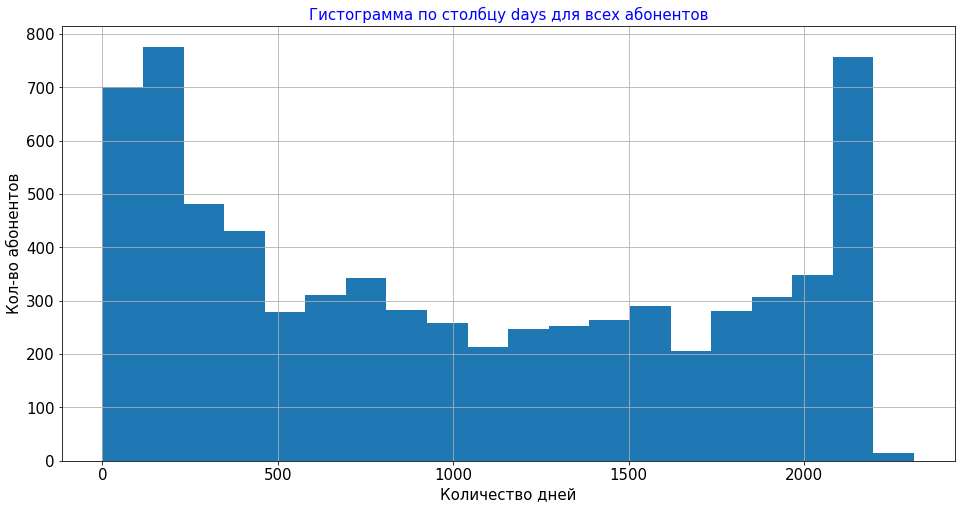

count    7043.000000
mean     1006.457050
std       736.596428
min         0.000000
25%       306.000000
50%       883.000000
75%      1706.000000
max      2314.000000
Name: days, dtype: float64


In [20]:
# Построение гистограммы для столбца months методом hist()
df_contract['days'].hist(bins=20, figsize=FIGSIZE_1)
plt.title('Гистограмма по столбцу days для всех абонентов', fontsize = FONTSIZE_1, color = 'blue')
plt.xlabel('Количество дней', fontsize = FONTSIZE_1)
plt.ylabel('Кол-во абонентов', fontsize = FONTSIZE_1)
plt.xticks(fontsize=FONTSIZE_1)
plt.yticks(fontsize=FONTSIZE_1)
plt.show()
# Просмотр основных параметров распределения в столбце методом describe()
print(df_contract['days'].describe())

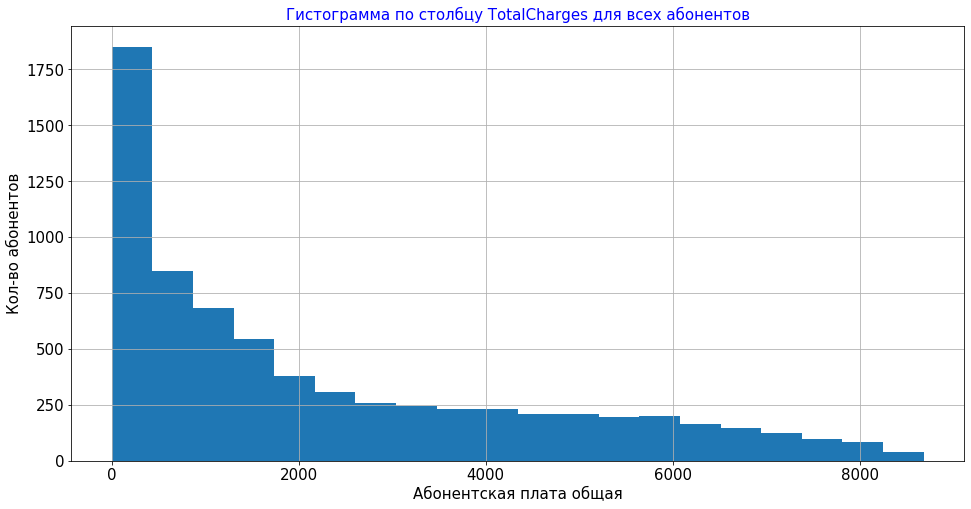

count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64


In [21]:
# Построение гистограммы для столбца TotalCharges методом hist()
df_contract['TotalCharges'].hist(bins=20, figsize=FIGSIZE_1)
plt.title('Гистограмма по столбцу TotalCharges для всех абонентов', fontsize = FONTSIZE_1, color = 'blue')
plt.xlabel('Абонентская плата общая', fontsize = FONTSIZE_1)
plt.ylabel('Кол-во абонентов', fontsize = FONTSIZE_1)
plt.xticks(fontsize=FONTSIZE_1)
plt.yticks(fontsize=FONTSIZE_1)
plt.show()
# Просмотр основных параметров распределения в столбце методом describe()
print(df_contract['TotalCharges'].describe())

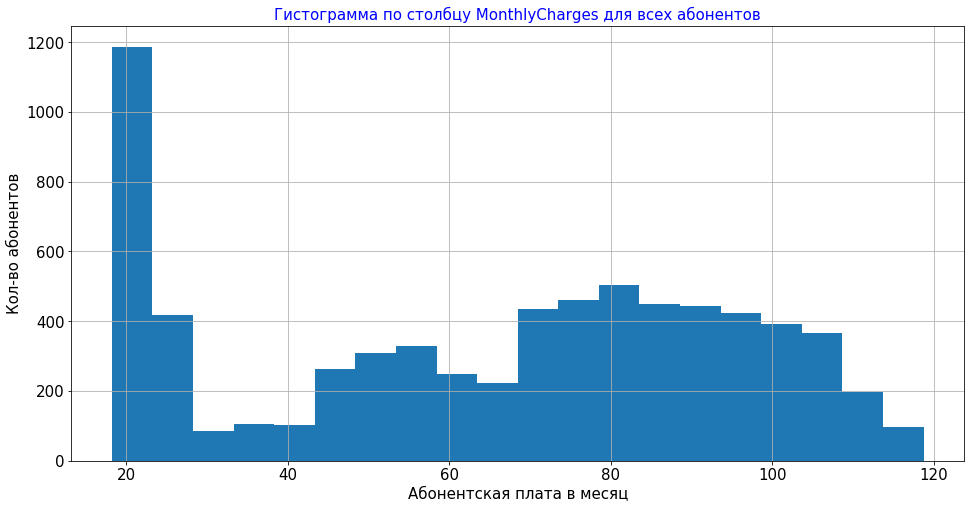

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64


In [22]:
# Построение гистограммы для столбца MonthlyCharges методом hist()
df_contract['MonthlyCharges'].hist(bins=20, figsize=FIGSIZE_1)
plt.title('Гистограмма по столбцу MonthlyCharges для всех абонентов', fontsize = FONTSIZE_1, color = 'blue')
plt.xlabel('Абонентская плата в месяц', fontsize = FONTSIZE_1)
plt.ylabel('Кол-во абонентов', fontsize = FONTSIZE_1)
plt.xticks(fontsize=FONTSIZE_1)
plt.yticks(fontsize=FONTSIZE_1)
plt.show()    
# Просмотр основных параметров распределения в столбце методом describe()
print(df_contract['MonthlyCharges'].describe())

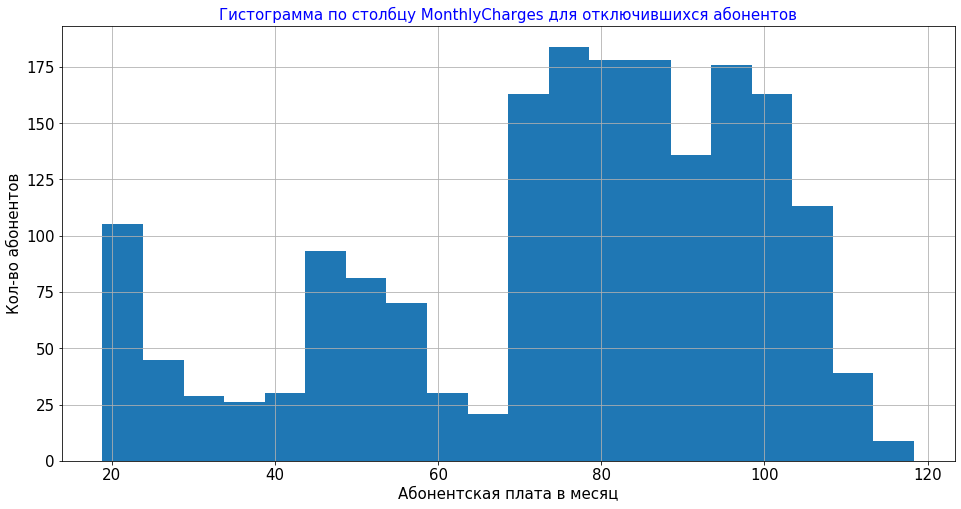

count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: MonthlyCharges, dtype: float64


In [23]:
# Построение гистограммы для столбца MonthlyCharges только для отключившихся абонентов методом hist() и выборкой query()
df_contract.query('EndDate != "No"')['MonthlyCharges'].hist(bins=20, figsize=FIGSIZE_1)
plt.title('Гистограмма по столбцу MonthlyCharges для отключившихся абонентов', fontsize = FONTSIZE_1, color = 'blue')
plt.xlabel('Абонентская плата в месяц', fontsize = FONTSIZE_1)
plt.ylabel('Кол-во абонентов', fontsize = FONTSIZE_1)
plt.xticks(fontsize=FONTSIZE_1)
plt.yticks(fontsize=FONTSIZE_1)
plt.show()
# Просмотр основных параметров распределения в столбце методом describe()
print(df_contract.query('EndDate != "No"')['MonthlyCharges'].describe())

#### Выводы:
- Наибольшее количество абонентов имеют абоненсткую плату до 30 у.е. в месяц.
- Наибольшее количество отключившихся абонентов имели абонентскую плату от 70 до 110 у.е. в месяц.

## 2. Построение модели

#### Список уточняющих вопросов
1. Что важнее для компании - удержать больше клиентов или получить модель с более высокой точностью предсказаний? В первом случае больше денег будет затрачено на скидки абонентам среди которых будут и те кто не собирались расторгать договор (ошибки предсказания модели); во втором случае денег на скидки будет затрачено меньше, но часть клиентов намеревающихся расторгнуть договор будут не предсказаны моделью и уйдут.

#### План решения задачи
1. Определить какие столбцы в исходных данных содержат полезную для построения модели информацию и станут признаками. Свести все признаки в одну таблицу.
1. Определить и создать столбец с целевым признаком. Не допустить утечки целевого признака.
1. Выполнить предподготовку признаков, а именно - перевести все признаки в цифровой вид применив одну из техник кодирования.
1. Обучить несколько моделей и сравнить их метрики на валидационной выборке. Выбрать модель с наилучшим значением метрики AUC-ROC.
1. Протестировать лучшую модель на тестовой выборке, получить метрику AUC-ROC >= 0.85 при этом не забывая про accuracy.
1. Написать отчёт по решению.

#### 2.1. Подготовка признаков

In [24]:
# Объединение таблиц contract и internet методом merge
df_merged = df_contract.merge(df_internet, on=['customerID'], how='left')

# Заполнение пропусков  методом fillna() в столбцах InternetService, OnlineSecurity ... StreamingMovies значением "No"
# для пользователей которые не подключили услугу Интернета.
df_merged = df_merged.fillna('No')

# Проверка заполнения пропусков
display(df_merged[df_merged['InternetService'] == 'No'].head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,days,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
11,7469-LKBCI,2018-10-01,No,Two year,No,Credit card (automatic),18.95,326.80,488.0,No,No,No,No,No,No,No
16,8191-XWSZG,2015-10-01,No,One year,No,Mailed check,20.65,1022.95,1584.0,No,No,No,No,No,No,No
21,1680-VDCWW,2019-02-01,No,One year,No,Bank transfer (automatic),19.80,202.25,365.0,No,No,No,No,No,No,No
22,1066-JKSGK,2019-11-01,2019-12-01 00:00:00,Month-to-month,No,Mailed check,20.15,20.15,92.0,No,No,No,No,No,No,No
33,7310-EGVHZ,2020-01-01,No,Month-to-month,No,Bank transfer (automatic),20.20,20.20,31.0,No,No,No,No,No,No,No


In [25]:
# Объединение таблиц df_merged и personal методом merge
df_merged = df_merged.merge(df_personal, on=['customerID'], how='left')

# Объединение таблиц df_merged и phone методом merge
df_merged = df_merged.merge(df_phone, on=['customerID'], how='left')

# Заполнение пропусков  методом fillna() в столбце MultipleLines значением "No"
# для пользователей которые не подключили услугу телефонии
df_merged = df_merged.fillna('No')

# Проверка заполнения пропусков
display(df_merged[df_merged['MultipleLines'] == 'No'].head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,days,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,31.0,DSL,...,Yes,No,No,No,No,Female,0,Yes,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,1036.0,DSL,...,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,123.0,DSL,...,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,1371.0,DSL,...,No,Yes,Yes,No,No,Male,0,No,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,153.0,Fiber optic,...,No,No,No,No,No,Female,0,No,No,No


In [26]:
# Проверка корректности полученной таблицы
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   days              7043 non-null   float64
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  gender            7043 non-null   object 


#### 2.2. Подготовка целевого признака
Целевым признаком в данной задаче является факт ухода клиента, значит нужно преобразовать столбец **EndDate**. Если значение в столбце является датой, то его нужно заменить на 1 = клиент ушёл, в противном случае заменить на 0 = клиент остался.

In [27]:
df_merged['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

#### Компании на заметку
- Абоненты уходили в период с октября 2019-го по январь 2020-го года - за 4 месяца отключились 1869 абонентов, причём равномерно в среднем по 467 абонентов в месяц.

In [28]:
# Создание нового столбца disconnected с целевым признаком с помощью написанной функции заполнения и метода apply
df_merged['disconnected'] = df_merged.apply(fill_target_fun, axis=1)

# Проверка корректности по количеству значений
print(df_merged['disconnected'].value_counts())

0    5174
1    1869
Name: disconnected, dtype: int64


In [29]:
# Удаление столбцов BeginDate и EndDate чтобы избежать утечки целевого признака методом drop
df_merged.drop(['BeginDate', 'EndDate'], axis='columns', inplace=True)

#### 2.3. Проверка корреляции количественных признаков

In [30]:
# Проверка корреляции количественных признаков методом corr()
display(df_merged.corr())

,MonthlyCharges,TotalCharges,days,SeniorCitizen,disconnected
MonthlyCharges,1.000000,0.651174,0.260860,0.220173,0.193356
TotalCharges,0.651174,1.000000,0.829418,0.103006,-0.198324
days,0.260860,0.829418,1.000000,0.023454,-0.311715
SeniorCitizen,0.220173,0.103006,0.023454,1.000000,0.150889
disconnected,0.193356,-0.198324,-0.311715,0.150889,1.000000


#### Вывод:
- Наблюдается сильная корреляция между столбцами **MonthlyCharges** и **TotalCharges**, а также между **TotalCharges** и **months**. Чтобы избежать мультиколлинеарности при обучении моделей следует удалить один из данных столбцов. Поскольку **TotalCharges** коррелирует с двумя другими столбцами удалим его.

In [31]:
# Удаление столбца TotalCharges методом drop
df_merged.drop(['TotalCharges'], axis='columns', inplace=True)

In [32]:
# Проверка полученной таблицы
display(df_merged)
df_merged.info()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,days,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,disconnected
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.0,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,No,0
1,5575-GNVDE,One year,No,Mailed check,56.95,1036.0,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,0
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,123.0,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No,1
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1371.0,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,No,0
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,153.0,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,One year,Yes,Mailed check,84.80,730.0,DSL,Yes,No,Yes,Yes,Yes,Yes,Male,0,Yes,Yes,Yes,0
7039,2234-XADUH,One year,Yes,Credit card (automatic),103.20,2191.0,Fiber optic,No,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,Yes,0
7040,4801-JZAZL,Month-to-month,Yes,Electronic check,29.60,337.0,DSL,Yes,No,No,No,No,No,Female,0,Yes,Yes,No,0
7041,8361-LTMKD,Month-to-month,Yes,Mailed check,74.40,215.0,Fiber optic,No,No,No,No,No,No,Male,1,Yes,No,Yes,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   days              7043 non-null   float64
 6   InternetService   7043 non-null   object 
 7   OnlineSecurity    7043 non-null   object 
 8   OnlineBackup      7043 non-null   object 
 9   DeviceProtection  7043 non-null   object 
 10  TechSupport       7043 non-null   object 
 11  StreamingTV       7043 non-null   object 
 12  StreamingMovies   7043 non-null   object 
 13  gender            7043 non-null   object 
 14  SeniorCitizen     7043 non-null   int64  
 15  Partner           7043 non-null   object 
 16  Dependents        7043 non-null   object 


#### 2.4. Предподготовка признаков для обучения модели

Опытным путём было определено, что следующие столбцы не влияют на метрики модели, поэтому их следует удалить из признаков:
- PaperlessBilling
- PaymentMethod
- OnlineBackup
- gender
- SeniorCitizen
- Partner
- Dependents
- MultipleLines

Для работы моделей необходимо выполнить кодирование признаков <br>
Для этого выполним преобразование категориальных признаков в численные техникой **OHE**

In [33]:
# Удаление столбцов не влияющих на метрики модели методом drop
df_merged.drop(['PaperlessBilling', 'PaymentMethod', 'OnlineBackup', 'gender', 'SeniorCitizen',
               'Partner', 'Dependents', 'MultipleLines'], axis='columns', inplace=True)

# Вызов функции pd.get_dummies с аргументов drop_first=True чтобы избежать дамми-ловушку
# Ненужные для обучения модели признаки исключаются методом drop с аргументом axis=1 и итоговая таблица записывается в df_model
df_model = pd.get_dummies(df_merged.drop(['customerID'], axis=1), drop_first=True)
display(df_model)

,MonthlyCharges,days,disconnected,Type_One year,Type_Two year,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
0,29.85,31.0,0,0,0,0,0,0,0,0,0,0
1,56.95,1036.0,0,1,0,0,0,1,1,0,0,0
2,53.85,123.0,1,0,0,0,0,1,0,0,0,0
3,42.30,1371.0,0,1,0,0,0,1,1,1,0,0
4,70.70,153.0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7038,84.80,730.0,0,1,0,0,0,1,1,1,1,1
7039,103.20,2191.0,0,1,0,1,0,0,1,0,1,1
7040,29.60,337.0,0,0,0,0,0,1,0,0,0,0
7041,74.40,215.0,1,0,0,1,0,0,0,0,0,0


#### 2.5. Разбиение данных на выборки

Поскольку для работы есть только одна таблица и нет отдельной тестовой выборки, то данные следует разделить на три части: обучающую, валидационную и тестовую в соотношении 3:1:1.

In [34]:
# Разделение данных на две части функцией train_test_split
# Сначала разделим данные на обучающую выборку и объединенную валидационную-тестовую
df_train, df_temp = train_test_split(df_model, test_size=0.4, random_state=RANDOM_STATE)
# Затем объёдинённую валидационную-тестовую выборки разделим на две равные выборки валидационную и тестовую
df_valid, df_test = train_test_split(df_temp, test_size=0.5, random_state=RANDOM_STATE)
# Удалим временную переменную
del df_temp

#### 2.6. Подготовка признаков и целевых признаков по трём выборкам

In [35]:
features_train = df_train.drop(['disconnected'], axis=1)
target_train = df_train['disconnected']

features_valid = df_valid.drop(['disconnected'], axis=1)
target_valid = df_valid['disconnected']

features_test = df_test.drop(['disconnected'], axis=1)
target_test = df_test['disconnected']

#### 2.7. Дисбаланс целевого признака

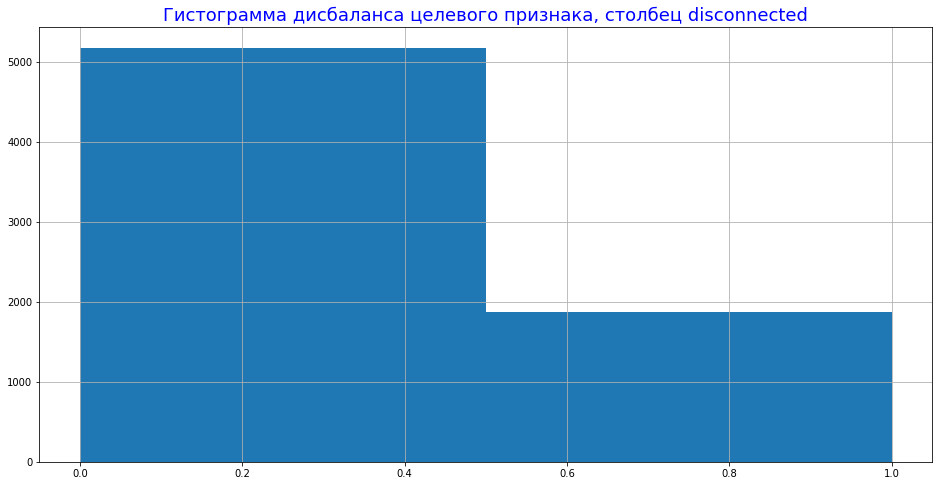

In [36]:
df_model['disconnected'].hist(bins=2, figsize=FIGSIZE_1)
plt.title('Гистограмма дисбаланса целевого признака, столбец disconnected', fontsize = 18, color = 'blue')
plt.show()

#### 2.8. Масштабирование признаков

In [37]:
# Масштабирование признаков с помощью StandardScaler()
scaler = StandardScaler()
scaler.fit(features_train)

features_train_scaled = scaler.transform(features_train)
features_valid_scaled = scaler.transform(features_valid)
features_test_scaled = scaler.transform(features_test)

#### 2.9. Обучение моделей логистической регрессии, решающего дерева и случайного леса

In [42]:
# Вызов написанной функции для обучения модели на исходных признаках   
model_train_fun(features_train, target_train, features_valid, target_valid)

Модель классификации решающее дерево:
max_depth = 2, f1 = 0.595, auc_roc = 0.753, accuracy = 0.660, recall = 0.921, precision = 0.439
max_depth = 3, f1 = 0.618, auc_roc = 0.778, accuracy = 0.691, recall = 0.921, precision = 0.465
max_depth = 4, f1 = 0.618, auc_roc = 0.818, accuracy = 0.691, recall = 0.921, precision = 0.464
max_depth = 5, f1 = 0.648, auc_roc = 0.840, accuracy = 0.762, recall = 0.809, precision = 0.541
max_depth = 6, f1 = 0.636, auc_roc = 0.838, accuracy = 0.765, recall = 0.757, precision = 0.548
max_depth = 7, f1 = 0.647, auc_roc = 0.841, accuracy = 0.745, recall = 0.861, precision = 0.518
max_depth = 8, f1 = 0.633, auc_roc = 0.832, accuracy = 0.749, recall = 0.796, precision = 0.525
max_depth = 9, f1 = 0.618, auc_roc = 0.816, accuracy = 0.730, recall = 0.806, precision = 0.501
max_depth = 10, f1 = 0.616, auc_roc = 0.795, accuracy = 0.737, recall = 0.777, precision = 0.510
max_depth = 11, f1 = 0.608, auc_roc = 0.788, accuracy = 0.730, recall = 0.772, precision = 0.502


In [43]:
# Обучение модели на масштабированных признаках
model_train_fun(features_train_scaled, target_train, features_valid_scaled, target_valid) 

Модель классификации решающее дерево:
max_depth = 2, f1 = 0.595, auc_roc = 0.753, accuracy = 0.660, recall = 0.921, precision = 0.439
max_depth = 3, f1 = 0.618, auc_roc = 0.778, accuracy = 0.691, recall = 0.921, precision = 0.465
max_depth = 4, f1 = 0.618, auc_roc = 0.818, accuracy = 0.691, recall = 0.921, precision = 0.464
max_depth = 5, f1 = 0.648, auc_roc = 0.840, accuracy = 0.762, recall = 0.809, precision = 0.541
max_depth = 6, f1 = 0.636, auc_roc = 0.838, accuracy = 0.765, recall = 0.757, precision = 0.548
max_depth = 7, f1 = 0.647, auc_roc = 0.841, accuracy = 0.745, recall = 0.861, precision = 0.518
max_depth = 8, f1 = 0.633, auc_roc = 0.832, accuracy = 0.749, recall = 0.796, precision = 0.525
max_depth = 9, f1 = 0.618, auc_roc = 0.816, accuracy = 0.730, recall = 0.806, precision = 0.501
max_depth = 10, f1 = 0.616, auc_roc = 0.795, accuracy = 0.737, recall = 0.777, precision = 0.510
max_depth = 11, f1 = 0.608, auc_roc = 0.788, accuracy = 0.730, recall = 0.772, precision = 0.502


#### 2.10. Тестирование модели случайного леса

In [44]:
model = RandomForestClassifier(max_depth=5, n_estimators=48, class_weight='balanced', random_state=RANDOM_STATE)
model.fit(features_train, target_train)
probabilities = model.predict_proba(features_test)
predictions = model.predict(features_test)

print('auc_roc на тестовой выборке = {:.3f}'.format(roc_auc_score(target_test, probabilities[:,1])))
print('accuracy на тестовой выборке = {:.3f}'.format(model.score(features_test, target_test)))
print('recall на тестовой выборке = {:.3f}'.format(recall_score(target_test, predictions)))
print('precision на тестовой выборке = {:.3f}'.format(precision_score(target_test, predictions)))

auc_roc на тестовой выборке = 0.832
accuracy на тестовой выборке = 0.739
recall на тестовой выборке = 0.780
precision на тестовой выборке = 0.515


#### 2.11. Обучение моделей градиентного бустинга LightGBM и CatBoostClassifier

In [45]:
# Подготовка признаков и целевого признака
features = df_model.drop('disconnected', axis=1)
target = df_model['disconnected']

# Разделим данные на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

In [46]:
%%time

## Обучение модели LightGBM
params = {
    'boosting_type': 'goss',
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': 5, 
    'learning_rate': 0.01,
    'verbose': 0
}
n_estimators = 400
#n_iters = 0
d_train = lgb.Dataset(features_train, label=target_train)
d_test = lgb.Dataset(features_test, label=target_test)
watchlist = [d_test]
 
model = lgb.train(params, d_train, n_estimators, watchlist, verbose_eval=50)

[50]	valid_0's auc: 0.851676
[100]	valid_0's auc: 0.854094
[150]	valid_0's auc: 0.855627
[200]	valid_0's auc: 0.85523
[250]	valid_0's auc: 0.854222
[300]	valid_0's auc: 0.85409
[350]	valid_0's auc: 0.85395
[400]	valid_0's auc: 0.853951
Wall time: 665 ms


#### 2.12. Обучение модели градиентного бустинга CatBoostClassifier

In [47]:
%%time
## Обучение модели CatBoost
model = CatBoostClassifier(iterations=300, learning_rate=0.01, max_depth=5, class_weights=[0.25, 1])
model.fit(features_train, target_train, verbose=20)

probabilities = model.predict_proba(features_test)
print('auc_roc на тестовой выборке = {:.3f}'.format(roc_auc_score(target_test, probabilities[:,1])))

0:	learn: 0.6884453	total: 123ms	remaining: 36.7s
20:	learn: 0.6156209	total: 219ms	remaining: 2.9s
40:	learn: 0.5688247	total: 290ms	remaining: 1.83s
60:	learn: 0.5363551	total: 370ms	remaining: 1.45s
80:	learn: 0.5146212	total: 439ms	remaining: 1.19s
100:	learn: 0.4992465	total: 507ms	remaining: 999ms
120:	learn: 0.4883566	total: 572ms	remaining: 846ms
140:	learn: 0.4795678	total: 660ms	remaining: 744ms
160:	learn: 0.4732544	total: 724ms	remaining: 625ms
180:	learn: 0.4680213	total: 799ms	remaining: 526ms
200:	learn: 0.4637897	total: 864ms	remaining: 426ms
220:	learn: 0.4602464	total: 944ms	remaining: 338ms
240:	learn: 0.4573324	total: 1.01s	remaining: 247ms
260:	learn: 0.4548590	total: 1.08s	remaining: 162ms
280:	learn: 0.4525891	total: 1.15s	remaining: 77.7ms
299:	learn: 0.4507668	total: 1.21s	remaining: 0us
auc_roc на тестовой выборке = 0.856
Wall time: 1.37 s


#### 2.13. Тестирование модели

In [48]:
# Проверка модели CatBoostClassifier на тестовой выборке
probabilities = model.predict_proba(features_test)
predictions = model.predict(features_test)
print('auc_roc на тестовой выборке = {:.3f}'.format(roc_auc_score(target_test, probabilities[:,1])))
print('accuracy на тестовой выборке = {:.3f}'.format(model.score(features_test, target_test)))
print('recall на тестовой выборке = {:.3f}'.format(recall_score(target_test, predictions)))
print('precision на тестовой выборке = {:.3f}'.format(precision_score(target_test, predictions)))

auc_roc на тестовой выборке = 0.856
accuracy на тестовой выборке = 0.710
recall на тестовой выборке = 0.907
precision на тестовой выборке = 0.479


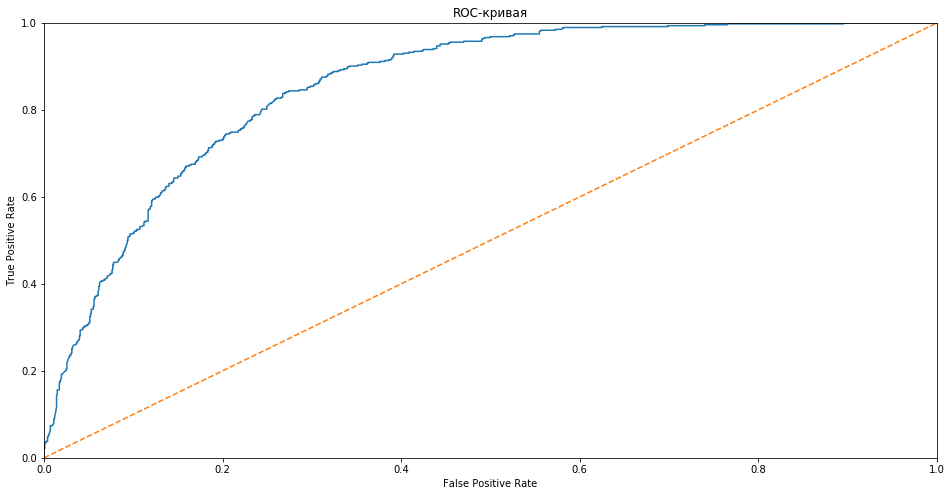

In [49]:
# Исследование метрики AUC-ROC
fpr, tpr, thresholds = roc_curve(target_test, probabilities[:,1])
plt.figure(figsize=FIGSIZE_1)
x=[0, 1]
y=[0, 1]
plt.plot(fpr, tpr,'-', x, y, '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

#### Вывод:
- Наибольшее значение метрики AUC-ROC = 0.856 при accuracy = 0.71 получилось у модели градиентного бустинга CatBoost.

#### 2.14. Оценка признаков модели

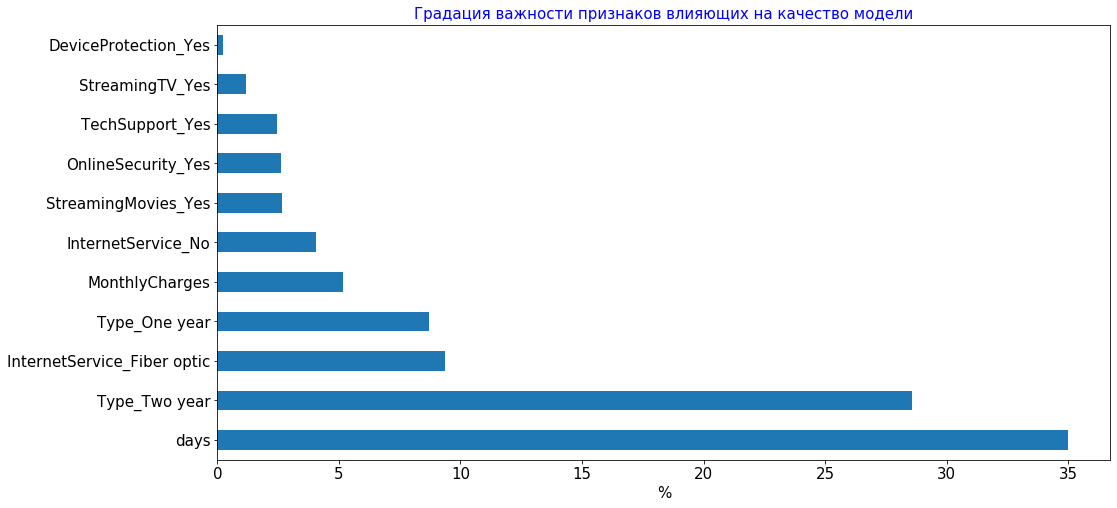

In [50]:
# Рассчёт влияния признаков на показатели качества модели
feat_importances = pd.Series(model.feature_importances_, index=features_test.columns)
feat_importances.nlargest(12).plot(kind='barh', figsize=FIGSIZE_1)
plt.title('Градация важности признаков влияющих на качество модели', fontsize = FONTSIZE_1, color = 'blue')
plt.xlabel('%', fontsize = FONTSIZE_1)
plt.xticks(fontsize=FONTSIZE_1)
plt.yticks(fontsize=FONTSIZE_1)
plt.show()

#### Вывод:
- Наиболее важными признаками для показателей качества модели являются: **days** и **Type_Two year** - 35% и 27% соответственно.
- Средними по важности признаками являются: **InternetService_Fiber optic** и **Type_One year** -  9% и 8% соответственно.
- Остальные признаки менее 5%.
- Признаки характеризующие личные данные абонентов (таблица **personal**) и сведения о количестве телефонных линий (таблица **phone**) оказались бесполезными для обучения модели.

## 3. Отчёт по решению

- Согласно намеченному плану работы над проектом все пункты были выполнены и сформулированы выводы. Дополнительно была выполнена проверка влияния масштабирования признаков на качество модели - не влияет, и учтён дисбаланс целевого признака - модель на сбалансированных данных показывает более высокие значения метрик.
- Ключевыми шагами в решении задачи проекта следует выделить следующие:
    1. Внимательно несколько раз прочитать задание
    1. Составить пошаговый план выполнения
    1. Разобраться в проблеме с различающимися размерами исходных таблиц
    1. Свести все данные в одну таблицу
    1. Выделить целевой признак и убрать признаки которые приводят к его утечке
    1. Определить можно ли по имеющимся данным создать новый признак
    1. Привести категориальные признаки в численный вид для обучения моделей
    1. Обучить модели, добиться плановых показателей метрик и выбрать лучшую модель
    1. Поочередно удаляя признаки определить какие из них не влияют на качество модели
    1. В итоговой таблице оставить только те признаки, которые влияют на качество модели
    1. Протестировать лучшую модель на тестовой выборке
- Итоговая модель выполнена на CatBoostClassifier, на входе 11 признаков, имеет метрики качества AUC-ROC = 0.856 при accuracy = 0.71.